# Method - 1

Since dataset is too large, it can be downloaded locally from here:  https://www.kaggle.com/datasets/shayanfazeli/heartbeat/data OR https://www.physionet.org/content/mitdb/1.0.0/
# CNN

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from scipy.signal import resample
import random
np.random.seed(42)

import torch
import torch.nn as nn
from torch.optim import Adam
from PIL import Image 
torch.manual_seed(42)
torch.backends.cudnn.benchmark = False

In [58]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'axes.grid':True,
         'axes.grid.which':'both'
         }
plt.rcParams.update(params)

# Read Dataset


In [59]:
df = pd.read_csv("mitbih_train.csv", header=None)
print(df.shape)
df2 = pd.read_csv("mitbih_test.csv", header=None)
# df = pd.concat([df, df2], axis=0)
df = df.reset_index().drop('index', axis='columns')

(87554, 188)


In [60]:
df.shape

(87554, 188)

# Define Target Labels

In [61]:
label_names = {0 : 'Normal',
              1: 'Supraventricular premature beat',
              2: 'Premature ventricular contraction',
              3: 'Fusion of ventricular and normal beat',
              4 : 'Unclassifiable beat'}

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB


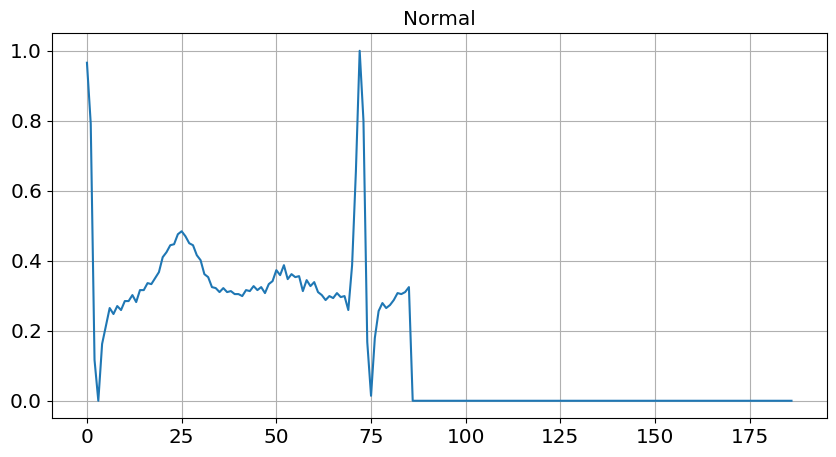

In [63]:
# show some data
plt.figure()
sample = df.sample(1).values.flatten()
y = label_names[sample[-1]]
plt.plot(sample[:-1])
t = plt.title(y)

## Distribution of labels
Checking how biased the dataset is

In [64]:
label=df[187].value_counts()
label

187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

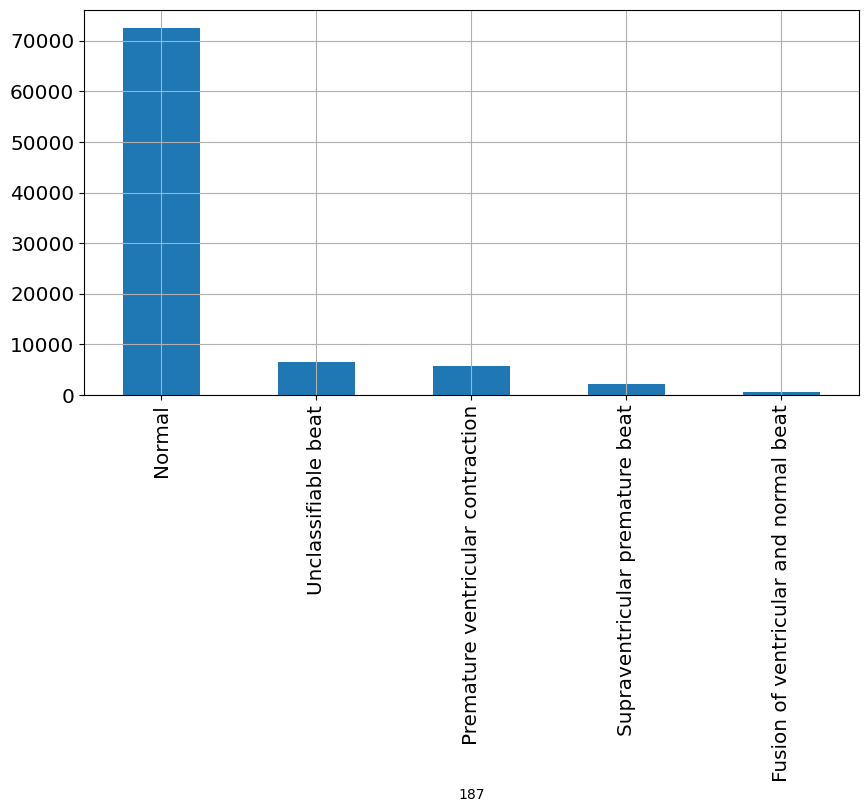

In [65]:
label.rename(label_names).plot.bar()
plt.savefig('dist.jpg', bbox_inches = 'tight')

In [66]:
label=df2[187].value_counts()
label

187
0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64

<Axes: xlabel='187'>

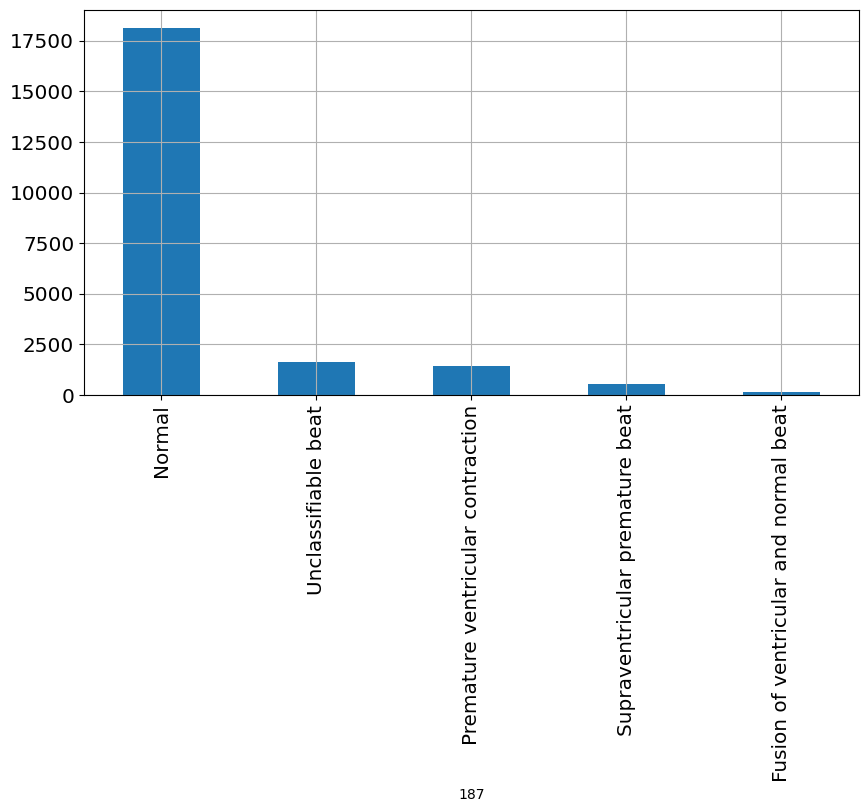

In [67]:
label.rename(label_names).plot.bar()

## Data augmentation

This shows that there is significant data imbalance. The majority of our training and testing points both are of type '0' (or category 'Normal'). This would influence our model in a negative way and keep producing those outputs as predictions. To have a balanced model, the data also needs to be balanced out.

In [68]:
def stretch(x):
    l = int(187 * (1 + (random.random()-0.5)/3))
    y = resample(x, l)
    if l < 187:
        y_ = np.zeros(shape=(187, ))
        y_[:l] = y
    else:
        y_ = y[:187]
    return y_

def amplify(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha)
    return x*factor


class Stretch:
    def __init__(self):
        pass
    
    def __call__(self,x):
        return stretch(x)
    
    def __repr__(self):
        return 'Stretch'
    
class Amplify:
    def __init__(self):
        pass
    
    def __call__(self,x):
        return amplify(x)
    
    def __repr__(self):
        return 'Amplify'

class Augment:
    def __init__(self, augmentation_list, return_prints = False):
        self.augmentation_list = augmentation_list
        self.return_prints = return_prints
        
    def __call__(self, x):
        augmentations_performed = ''
        
        for augmentation in self.augmentation_list:
            if np.random.binomial(1, 0.5) == 1:
                x = augmentation(x)
                augmentations_performed += f'{augmentation} '
                
        if not self.return_prints:
            return x
        return x, augmentations_performed



Lets look at the augmentations... In blue the original. In orange the augmented. It is always a good idea to know what the input is to the network exactly.

In [69]:
# augment = Augment([Amplify(), Stretch()], True)
# for _ in range(3):
#     plt.figure()
#     sample = df.sample(1).values.flatten()
#     y = label_names[sample[-1]]
#     plt.plot(sample[:-1])
#     plt.xlim(-10, 100)
    
#     augmented, augmentations_performed = augment(sample[:-1])
#     plt.plot(augmented[:-1])
    
#     title = plt.title(y + ' ' + augmentations_performed)

## 3 Way Split: Training, Validation and Test

In [70]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, train_size=0.8, stratify=df.iloc[:,-1])
test_df = df2

for dataframe in [train_df, val_df, test_df]:
    print(dataframe.iloc[:,-1].value_counts(normalize=True))
    print('\n')

187
0.0    0.827734
4.0    0.073455
2.0    0.066102
1.0    0.025384
3.0    0.007324
Name: proportion, dtype: float64


187
0.0    0.827708
4.0    0.073440
2.0    0.066130
1.0    0.025413
3.0    0.007310
Name: proportion, dtype: float64


187
0.0    0.827608
4.0    0.073451
2.0    0.066143
1.0    0.025397
3.0    0.007400
Name: proportion, dtype: float64




### Undersampling class 0 or Normal

187
0.0    57977
1.0     1778
2.0     4630
3.0      513
4.0     5145
dtype: int64

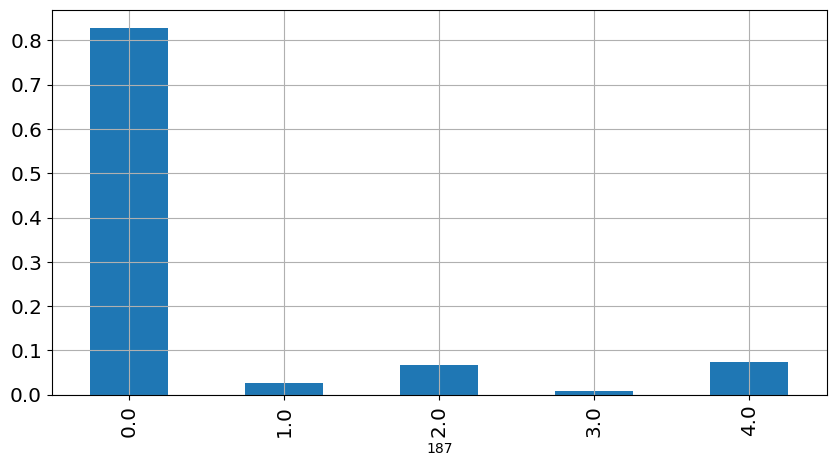

In [71]:
col = train_df.groupby(187).size()
(col / col.sum()).plot.bar()
col

Limit (N) and sample 5000 samples, randomly. These will be used for training and the rest are ignored.

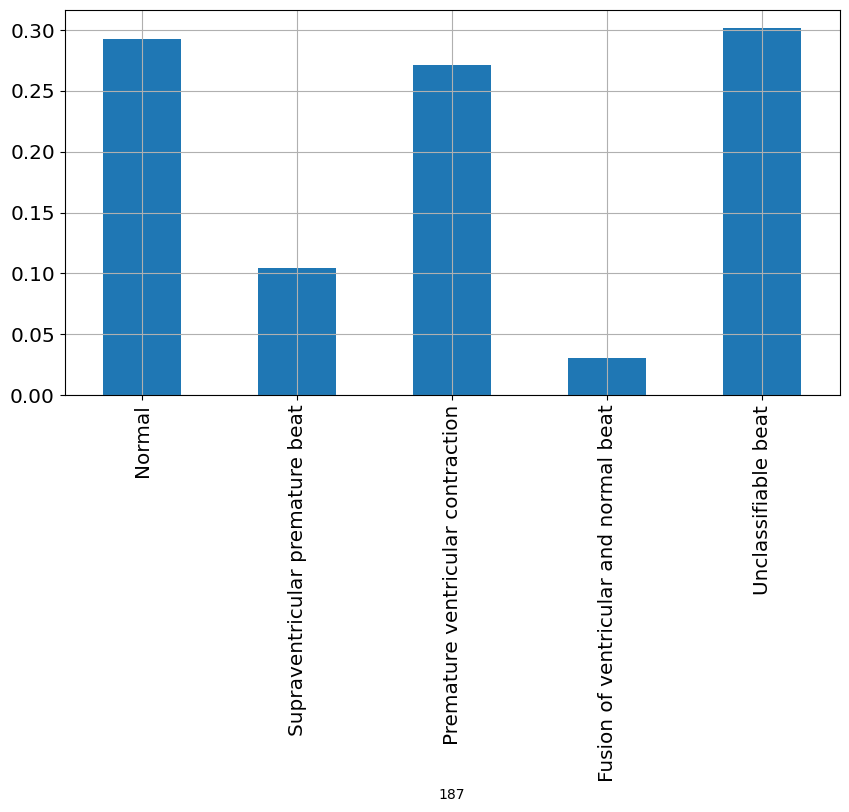

In [77]:
non_normal_rows = train_df.loc[train_df.iloc[:,-1] != 0]
normal_rows = train_df.loc[train_df.iloc[:,-1] == 0].sample(5000)

train_df = pd.concat([non_normal_rows, normal_rows])

col = train_df.groupby(187).size()
(col / col.sum()).rename(label_names).plot.bar()
col
plt.savefig('balanced.jpg',bbox_inches = 'tight')

## Model

In [32]:
class A(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.intro_bn = nn.BatchNorm1d(32)
    
        self.C11 = nn.Conv1d(32, 32, kernel_size=5, padding=2)
        self.A11 = nn.ReLU()
        self.C12 = nn.Conv1d(32, 32, kernel_size=5, padding=2)
        self.A12 = nn.ReLU()
        self.M11 = nn.MaxPool1d(kernel_size=5, stride=2)

    def forward(self, x):
        x = self.intro_bn(x)
        C = x
        x = self.C11(x)
        x = self.A11(x)
        x = self.C12(x)
        x = x + C
        x = self.A12(x)
        x = self.M11(x)
        
        return x
    
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_in = nn.Conv1d(1, 32, kernel_size=5)
        
        self.A_blocks = nn.ModuleList(A() for i in range(5))
        
        self.avg_pool = nn.AvgPool1d(2)
        self.fc1 = nn.Linear(32,32)
        self.acc1 = nn.ReLU()
        self.fc2 = nn.Linear(32,5)
        
    def forward(self, x):
        x = self.conv_in(x)
        
        for i in range(5):
            x = self.A_blocks[i](x)
        
        x = self.avg_pool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.acc1(x)
        x = self.fc2(x)
        
        return x
    

In [33]:
batch_size = 256
epochs = 10 # 75
lr = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_splits = 7

In [34]:
from torch.utils.data import Dataset, DataLoader

class ds(Dataset):
  def __init__(self, x, y=None, transforms=None):
    super().__init__()

    self.X = x
    self.Y = y
    self.transforms = transforms

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self,idx):
    x = self.X.iloc[idx,:]
    
    if self.transforms is not None:
        x = self.transforms(x)

    if self.Y is not None:
      return torch.Tensor(x).view(1,-1).float(), torch.Tensor([self.Y.iloc[idx]]).float().squeeze()

    return torch.Tensor(x).float()

augment = Augment([Amplify(), Stretch()])

train_set = ds(train_df.iloc[:,:-1], train_df.iloc[:,-1], transforms=augment)
val_set = ds(val_df.iloc[:,:-1], val_df.iloc[:,-1])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size*4)

## Model Training

In [35]:
criterion = nn.CrossEntropyLoss()
from torch.optim.lr_scheduler import ReduceLROnPlateau

Using the Adam Optimizer


In [36]:
epoch_train_losses = []
epoch_val_losses = []

from sklearn.model_selection import KFold
kf = KFold(n_splits=n_splits)
for fold_n, (train_idx, val_idx) in enumerate(kf.split(df)):
    train_set = ds(df.iloc[train_idx,:-1], df.iloc[train_idx,-1], transforms=augment)
    val_set = ds(df.iloc[val_idx,:-1], df.iloc[val_idx,-1])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size*4)
    
    model = Model().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    lr_sched = ReduceLROnPlateau(optimizer, patience=3)
    for epoch in range(epochs):
        epoch_train_loss = 0
        epoch_val_loss = 0

        model.train()
        for batch_id, (x,y_true) in enumerate(train_loader):
            y_pred = model(x.to(device))

            optimizer.zero_grad()
            loss = criterion(y_pred, y_true.long().to(device))
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item() / len(train_loader)

        model.eval()
        with torch.no_grad():
            for batch_id, (x,y_true) in enumerate(val_loader):
                y_pred = model(x.to(device))
                loss = criterion(y_pred, y_true.long().to(device))

                epoch_val_loss += loss.item() / len(val_loader)


        epoch_train_losses.append(epoch_train_loss)
        epoch_val_losses.append(epoch_val_loss)
        print(f'Fold {fold_n} Epoch {epoch}:\tTrain loss: {epoch_train_loss:0.2e}\tVal loss: {epoch_val_loss:0.2e} \tLR: {optimizer.param_groups[0]["lr"]:0.2e}')

        if lr_sched is None:
            if epoch % 10 == 0 and epoch > 0:
                optimizer.param_groups[0]['lr'] /= 10
                print(f'Reducing LR to {optimizer.param_groups[0]["lr"]}')
        else:
            lr_sched.step(epoch_val_loss)
    torch.save(model.state_dict(), f'model_fold_{fold_n}.pth')


Fold 0 Epoch 0:	Train loss: 2.67e-01	Val loss: 3.76e-02 	LR: 1.00e-03
Fold 0 Epoch 1:	Train loss: 1.16e-01	Val loss: 4.68e-02 	LR: 1.00e-03
Fold 0 Epoch 2:	Train loss: 9.02e-02	Val loss: 2.82e-02 	LR: 1.00e-03
Fold 0 Epoch 3:	Train loss: 7.87e-02	Val loss: 6.09e-02 	LR: 1.00e-03
Fold 0 Epoch 4:	Train loss: 6.95e-02	Val loss: 3.31e-02 	LR: 1.00e-03
Fold 0 Epoch 5:	Train loss: 6.16e-02	Val loss: 1.80e-02 	LR: 1.00e-03
Fold 0 Epoch 6:	Train loss: 5.72e-02	Val loss: 2.21e-02 	LR: 1.00e-03
Fold 0 Epoch 7:	Train loss: 5.29e-02	Val loss: 1.70e-02 	LR: 1.00e-03
Fold 0 Epoch 8:	Train loss: 4.97e-02	Val loss: 3.10e-02 	LR: 1.00e-03
Fold 0 Epoch 9:	Train loss: 4.82e-02	Val loss: 3.19e-02 	LR: 1.00e-03
Fold 1 Epoch 0:	Train loss: 2.49e-01	Val loss: 7.00e-02 	LR: 1.00e-03
Fold 1 Epoch 1:	Train loss: 1.15e-01	Val loss: 4.18e-02 	LR: 1.00e-03
Fold 1 Epoch 2:	Train loss: 9.21e-02	Val loss: 1.20e-02 	LR: 1.00e-03
Fold 1 Epoch 3:	Train loss: 7.65e-02	Val loss: 2.37e-02 	LR: 1.00e-03
Fold 1 Epoch 4:	Trai

Save the loss values to a csv for further plotting

In [ ]:
loss_df = pd.DataFrame({
    'Epoch_Train_Loss': epoch_train_losses,
    'Epoch_Val_Loss': epoch_val_losses
})

# Save the DataFrame to a CSV file
loss_df.to_csv('loss_values.csv', index=False)

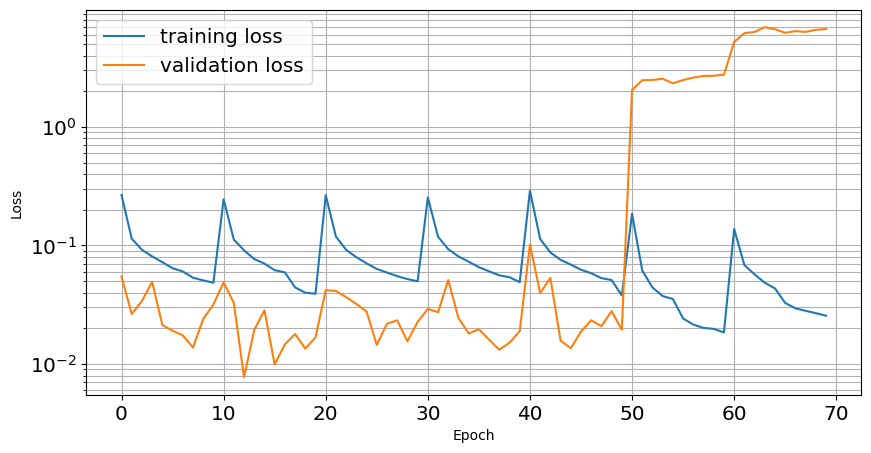

In [80]:
temp = pd.read_csv('loss_values.csv')
plt.plot(temp['Epoch_Train_Loss'])
plt.plot(temp['Epoch_Val_Loss'])
plt.legend(['training loss','validation loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.savefig('loss.jpg', bbox_inches = 'tight')

## Model Validation

In [38]:
predictions = []
labels = []

model.eval()
with torch.no_grad():
    for batch_id, (x,y_true) in enumerate(val_loader):
        y_pred = model(x.to(device)).argmax(1)
        
        predictions.extend(y_pred.squeeze().tolist())
        labels.extend(y_true.squeeze().tolist())
        
prediction_labels = pd.DataFrame(np.array([predictions, labels]).T, columns=['Prediction', 'Label'])
cm = prediction_labels.groupby(['Prediction', 'Label']).size()
cm.unstack(0)

Prediction   0.0  1.0   2.0
Label                      
2.0          951  187  4297
3.0          540    4    97
4.0         3899   11  2521

In [39]:
print(classification_report(predictions, labels))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      5390
         1.0       0.00      0.00      0.00       202
         2.0       0.79      0.62      0.70      6915
         3.0       0.00      0.00      0.00         0
         4.0       0.00      0.00      0.00         0

    accuracy                           0.34     12507
   macro avg       0.16      0.12      0.14     12507
weighted avg       0.44      0.34      0.38     12507



c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1469: Und

## Test the model - Test set

In [40]:
test_set = ds(test_df.iloc[:,:-1], test_df.iloc[:,-1])
test_loader = DataLoader(test_set, batch_size=batch_size*4, shuffle=False)

predictions = []

model.eval()
with torch.no_grad():
    for fold in range(n_splits):
        model = Model().to(device)
        model.load_state_dict(torch.load(f'model_fold_{fold}.pth'))
        model.eval()
        
        fold_predictions = []
        labels = []
        for batch_id, (x,y_true) in enumerate(test_loader):
            y_pred = model(x.to(device)).argmax(1)

            fold_predictions.extend(y_pred.squeeze().tolist())
            labels.extend(y_true.squeeze().tolist())
        predictions.append(fold_predictions)
    
predictions.append(labels)
all_prediction_labels = pd.DataFrame(
    np.array(predictions).T, 
    columns=[f'fold {n}' for n in range(n_splits)] + ['Label']
#     columns=['fold 0', 'fold 1', 'fold 2','fold 3','fold 4', 'Label'],
#     columns=['fold 0', 'fold 1', 'fold 3', 'Label']
)

final_predictions = all_prediction_labels.iloc[:,:-1].mode(1).iloc[:,0]
prediction_labels = pd.DataFrame(
    np.hstack([
        final_predictions.values.reshape(-1,1), 
        all_prediction_labels.loc[:,'Label'].values.reshape(-1,1)]
    ),
    columns=['Prediction', 'Label']
)
prediction_labels

cm = prediction_labels.groupby(['Prediction', 'Label']).size()
cm.unstack(0)

Prediction      0.0    1.0     2.0    3.0     4.0
Label                                            
0.0         18076.0   33.0     6.0    2.0     1.0
1.0           103.0  442.0    11.0    NaN     NaN
2.0            35.0    3.0  1401.0    8.0     1.0
3.0            20.0    NaN    22.0  120.0     NaN
4.0            10.0    NaN     2.0    NaN  1596.0

In [41]:
predictions = prediction_labels.loc[:,'Prediction'].values
labels = prediction_labels.loc[:,'Label'].values
print(classification_report(predictions, labels))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     18244
         1.0       0.79      0.92      0.85       478
         2.0       0.97      0.97      0.97      1442
         3.0       0.74      0.92      0.82       130
         4.0       0.99      1.00      1.00      1598

    accuracy                           0.99     21892
   macro avg       0.90      0.96      0.93     21892
weighted avg       0.99      0.99      0.99     21892

